# TIME SERIES - WEATHER FORECAST OF KOCAELI

## PRACTICES IN THIS NOTEBOOK

* Time series
* Gradient Boosting Regressor
* Deep Learning
* LSTM

## DATA SOURCE

The data used in this analysis has been downloaded from open-meteo.com. It belongs to my hometown of Kocaeli, Turkey, and includes weather information spanning from January 1, 2020, to September 29, 2024. This dataset encompasses various weather parameters, with a particular focus on mean temperatures, which will be evaluated and forecasted.

The analysis aims to uncover trends and patterns in the temperature data, providing valuable insights for understanding local climate behavior over this period. Additionally, the forecasting component will utilize advanced modeling techniques to predict future temperature trends, contributing to more informed decision-making in fields such as agriculture, urban planning, and environmental conservation.

# Introduction

In this notebook, the primary objective is to practice time series analysis by comparing various machine learning and deep learning models. The performance of these models will be evaluated using the R² score as the decision metric. To facilitate a comprehensive comparison, predictions will be visually contrasted with actual values on a line plot, displayed in an annual format.

r2 score = 
$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$

* $y_i$ is the actual value,
* $\hat{y}_i$  is the predicted value,
* $\bar{y}$  is the mean of the actual values.

# 1. Import Libraries

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt

# Date and time manipulation
import datetime

# Machine learning preprocessing
from sklearn.preprocessing import StandardScaler

# Machine learning models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# Deep learning with TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set the Seaborn pastel style
plt.style.use('seaborn-v0_8-pastel')

# 3. Load Data

In [2]:
df_main = pd.read_csv("kocaeli2020_2024.csv")
df = df_main.copy()

In [3]:
df.head()

,latitude,longitude,elevation,utc_offset_seconds,timezone,timezone_abbreviation
0,40.738136,29.872341,6.0,10800,Africa/Cairo,EEST
1,time,temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),NaN,NaN
2,2020-01-01,7.3,4.4,6.1,NaN,NaN
3,2020-01-02,7.7,2.7,4.9,NaN,NaN
4,2020-01-03,7.8,2.3,4.9,NaN,NaN


In [4]:
df_main = pd.read_csv("kocaeli2020_2024.csv", skiprows=2)
print("Shape of the dataframe: {}".format(df.shape))

Shape of the dataframe: (1738, 6)


# 4. Preprocessing

In [5]:
df.head()

,latitude,longitude,elevation,utc_offset_seconds,timezone,timezone_abbreviation
0,40.738136,29.872341,6.0,10800,Africa/Cairo,EEST
1,time,temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),NaN,NaN
2,2020-01-01,7.3,4.4,6.1,NaN,NaN
3,2020-01-02,7.7,2.7,4.9,NaN,NaN
4,2020-01-03,7.8,2.3,4.9,NaN,NaN


In [6]:
df_main["time"] = pd.to_datetime(df_main["time"], format="%Y-%m-%d")
df_main = df_main[df_main["time"] != "2020-02-29"]
df_main = df_main[df_main["time"] != "2024-09-30"]
df_main = df_main[df_main["time"] != "2024-10-01"]
df_main = df_main.rename(columns={'temperature_2m_max (°C)': "temp_max", 'temperature_2m_min (°C)':'temp_min', 'temperature_2m_mean (°C)': "temp_mean"})

In [7]:
df_main.time.dt.year.value_counts()

time
2020    365
2021    365
2022    365
2023    365
2024    273
Name: count, dtype: int64

In [8]:
df = df_main.copy()

In [9]:
df.drop(['time', 'temp_max', 'temp_min'], axis = 1, inplace=True)

In [10]:
scaler = StandardScaler()
scaler.fit(df.iloc[:-275,:])
df = scaler.transform(df)

# Note: now df is not a dataframe, but a numpy array.

# 5. Univariate One Step Ahead Forecasting

## 5.1. Machine Learning - Gradient Boosting

**Explanation of preprocess function:**

For machine learning we need input matrix and output vector.

Generate first matrix as X
Generate second matrix as y

$
\begin{bmatrix}
x_0 & x_1 & x_2 \\
x_1 & x_2 & x_3 \\
\vdots & \vdots & \vdots \\
x_{t-4} & x_{t-3} & x_{t-2}
\end{bmatrix}
$
$
\begin{bmatrix}
x_3 \\
x_4 \\
\vdots \\
x_{t-1}
\end{bmatrix}
$

In [11]:
# look 365 days back:

def preprocess(data, lag = 365):
  X = []
  y = []
  for i in range(len(data) - lag):
    X.append(data[i : i + lag])
    y.append(data[i + lag])
  return np.array(X), np.array(y)

X, y = preprocess(df[:,0], lag = 365)
print(X.shape)
print(y.shape)

(1368, 365)
(1368,)


In [12]:
# proceed with 2024 as test data. Rest is for training:

X_train = X[:-273]
y_train = y[:-273]
X_test = X[-273:]
y_test = y[-273:]

In [13]:
# build a model

mdl = GradientBoostingRegressor()
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)

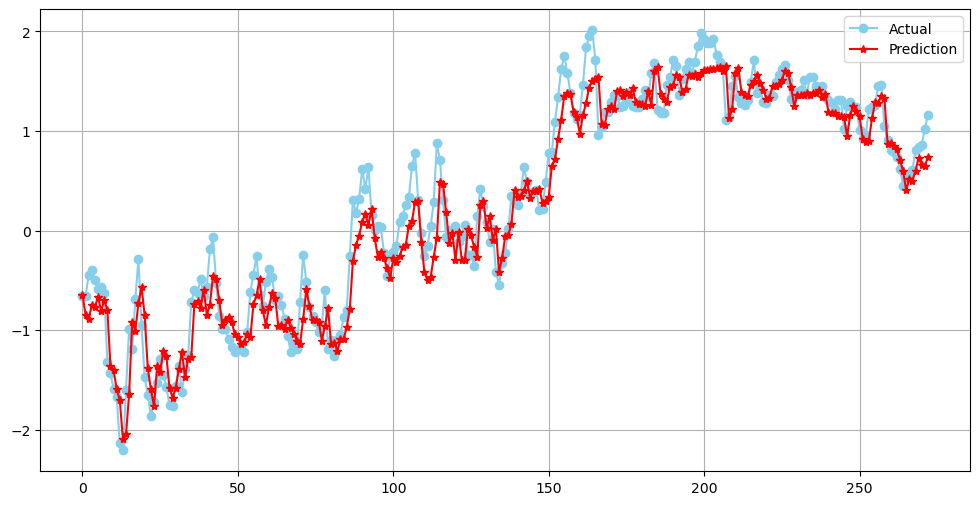

R2 score is:  0.9434829170886816 




In [14]:
plt.figure(figsize=(12,6))
plt.plot(y_test, "-o", label = "Actual", color="skyblue")
plt.plot(y_pred, "-*r", label = "Prediction")
plt.legend()
plt.grid()
plt.show()
print("R2 score is: ", r2_score(y_test, y_pred),"\n\n")

## 5.2. Deep Learning - LSTM 

Tranform data according to LSTM format:

$
\begin{bmatrix}
\begin{bmatrix}
x_0 \\
x_1 \\
x_2
\end{bmatrix} \\
\begin{bmatrix}
x_1 \\
x_2 \\
x_3
\end{bmatrix} \\
\vdots \\
\begin{bmatrix}
x_{t-4} \\
x_{t-3} \\
x_{t-2}
\end{bmatrix}
\end{bmatrix}
$
$
\begin{bmatrix}
x_3 \\
x_4 \\
\vdots \\
x_{t-1}
\end{bmatrix}
$

In [15]:
def preprocess(data, lag = 3):
  X = []
  y = []
  for i in range(len(data) - lag):
    X.append(data[i : i + lag])
    y.append(data[i + lag])
  return np.array(X), np.array(y)

X, y = preprocess(df[:,0], lag = 365)
X = X[..., np.newaxis] #preserve previous dimensions and add new one
print(X.shape)
print(y.shape)

(1368, 365, 1)
(1368,)


In [16]:
X_train = X[:-273]
y_train = y[:-273]
X_test = X[-273:]
y_test = y[-273:]

In [17]:
mdl = keras.Sequential()
mdl.add(layers.Input(shape=X_train.shape[1:])) # shape -> (365,1) matrix
mdl.add(layers.LSTM(128))
mdl.add(layers.Dense(128, activation="relu"))
mdl.add(layers.Dense(1, activation="linear")) # linear --> continious

mdl.compile(optimizer="adam", loss="mse", metrics=["mape"])
mdl.fit(X_train, y_train, epochs=10, verbose=1)

y_pred = mdl.predict(X_test)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.4015 - mape: 215.5800
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.1413 - mape: 248.7922
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.1316 - mape: 293.2530
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.1206 - mape: 278.6536
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.1011 - mape: 214.8058
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0866 - mape: 228.4771
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0851 - mape: 345.1555
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0791 - mape: 129.6046
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0760 - mape: 164.5016
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0641 - mape: 127.1723
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


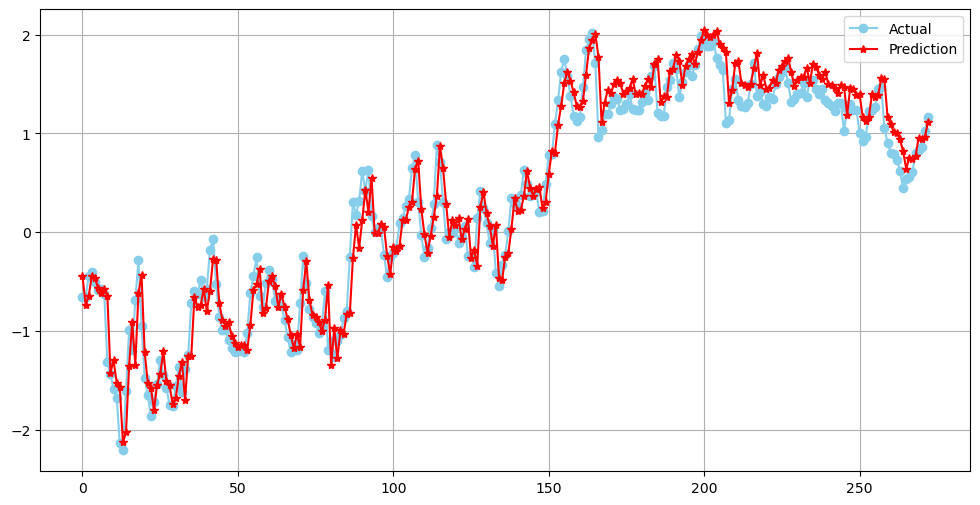

R2 score is:  0.9517128241007684 




In [18]:
plt.figure(figsize=(12,6))
plt.plot(y_test, "-o", label = "Actual", color="skyblue")
plt.plot(y_pred, "-*r", label = "Prediction")
plt.legend()
plt.grid()
plt.show()
print("R2 score is: ", r2_score(y_test, y_pred),"\n\n")

# 6. Multivariate One Step Ahead Forecasting

## 6.1. Machine Learning - Gradient Boosting

$$x_0, x_1, x_2, x_3, x_4, ... , x_{t-1}$$
$$y_0, y_1, y_2, y_3, y_4, ... , y_{t-1}$$

$$\hat{x}_3 = f(x_0, y_0, x_1, y_1, x_2, y_2) $$

$$
\begin{bmatrix}
x_0 & y_0 & x_1 & y_1 & x_2 & y_2 \\
x_1 & y_1 & x_2 & y_2 & x_3 & y_3 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
x_{t-4} & y_{t-4} & x_{t-3} & y_{t-3} & x_{t-2} & y_{t-2} \\
\end{bmatrix}
\quad
\begin{bmatrix}
x_3 \\
x_4 \\
\vdots\\
x_{t-1} \\
\end{bmatrix}
$$

## 6.1.1. Preprocess

In [19]:
df_main.columns

Index(['time', 'temp_max', 'temp_min', 'temp_mean'], dtype='object')

In [20]:
df = df_main[["temp_mean", "temp_min"]];

In [21]:
scaler = StandardScaler()
scaler.fit(df.iloc[:-275,:])
df = scaler.transform(df)

In [22]:
i = 0
data = df
lag = 3
data[i : i + lag]

array([[-1.37528329, -1.08622538],
       [-1.54752473, -1.34328541],
       [-1.54752473, -1.40377012]])

## 6.1.2. Modelling

In [23]:
def preprocess(data, lag = 3, target_col = 0):
  X = []
  y = []
  for i in range(len(data) - lag):
    X.append(data[i : i + lag].ravel())
    y.append(data[i + lag, target_col])
  return np.array(X), np.array(y)

X, y = preprocess(df, lag = 365, target_col = 0)
print(X.shape)
print(y.shape)

X_train = X[:-273]
y_train = y[:-273]
X_test = X[-273:]
y_test = y[-273:]

(1368, 730)
(1368,)


In [24]:
mdl = GradientBoostingRegressor()
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)

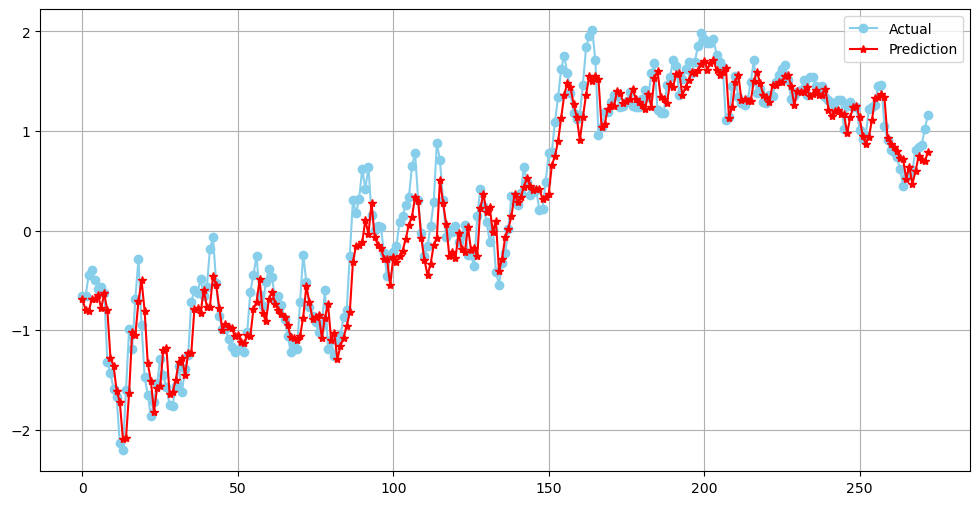

R2 score is:  0.9460102007158421 




In [25]:
plt.figure(figsize=(12,6))
plt.plot(y_test, "-o", label = "Actual", color="skyblue")
plt.plot(y_pred, "-*r", label = "Prediction")
plt.legend()
plt.grid()
plt.show()
print("R2 score is: ", r2_score(y_test, y_pred),"\n\n")

## 6.2. Deep Learning - LSTM

$$x_0, x_1, x_2, x_3, x_4, ... , x_{t-1}$$
$$y_0, y_1, y_2, y_3, y_4, ... , y_{t-1}$$

$$\hat{x}_3 = f(x_0, y_0, x_1, y_1, x_2, y_2) $$

$$
\begin{bmatrix}
\begin{bmatrix}x_0 & y_0 \\ x_1 & y_1 \\ x_2 & y_2 \end{bmatrix} \\
\begin{bmatrix}x_1 & y_1 \\ x_2 & y_2 \\ x_3 & y_3 \end{bmatrix} \\
\vdots \\
\begin{bmatrix}x_{t-4} & y_{t-4} \\ x_{t-3} & y_{t-3} \\ x_{t-2} & y_{t-2}\end{bmatrix} \\
\end{bmatrix}
\quad
\begin{bmatrix}
x_3 \\
x_4 \\
\vdots\\
x_{t-1} \\
\end{bmatrix}
$$

In [26]:
def preprocess(data, lag = 3, target_col = 0):
  X = []
  y = []
  for i in range(len(data) - lag):
    X.append(data[i : i + lag])
    y.append(data[i + lag, target_col])
  return np.array(X), np.array(y)

X, y = preprocess(df, lag = 365, target_col = 0)
print(X.shape)
print(y.shape)

(1368, 365, 2)
(1368,)


In [27]:
X_train = X[:-273]
y_train = y[:-273]
X_test = X[-273:]
y_test = y[-273:]

In [28]:
mdl = keras.Sequential()
mdl.add(layers.Input(shape=X_train.shape[1:]))
mdl.add(layers.LSTM(128))
mdl.add(layers.Dense(128, activation = "relu"))
mdl.add(layers.Dense(1, activation = "linear"))

mdl.compile(optimizer = "adam", loss = "mse", metrics = ["mape"])
mdl.fit(X_train, y_train, epochs = 10, verbose = 2)

y_pred = mdl.predict(X_test)

Epoch 1/10
35/35 - 4s - 113ms/step - loss: 0.2575 - mape: 241.4902
Epoch 2/10
35/35 - 4s - 106ms/step - loss: 0.1454 - mape: 254.0044
Epoch 3/10
35/35 - 3s - 94ms/step - loss: 0.1276 - mape: 245.9882
Epoch 4/10
35/35 - 3s - 97ms/step - loss: 0.1144 - mape: 237.9250
Epoch 5/10
35/35 - 3s - 99ms/step - loss: 0.1057 - mape: 229.9221
Epoch 6/10
35/35 - 3s - 95ms/step - loss: 0.0989 - mape: 213.8545
Epoch 7/10
35/35 - 3s - 98ms/step - loss: 0.0903 - mape: 191.9566
Epoch 8/10
35/35 - 3s - 96ms/step - loss: 0.0836 - mape: 183.0230
Epoch 9/10
35/35 - 3s - 96ms/step - loss: 0.0788 - mape: 184.0453
Epoch 10/10
35/35 - 3s - 95ms/step - loss: 0.0732 - mape: 163.7322
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


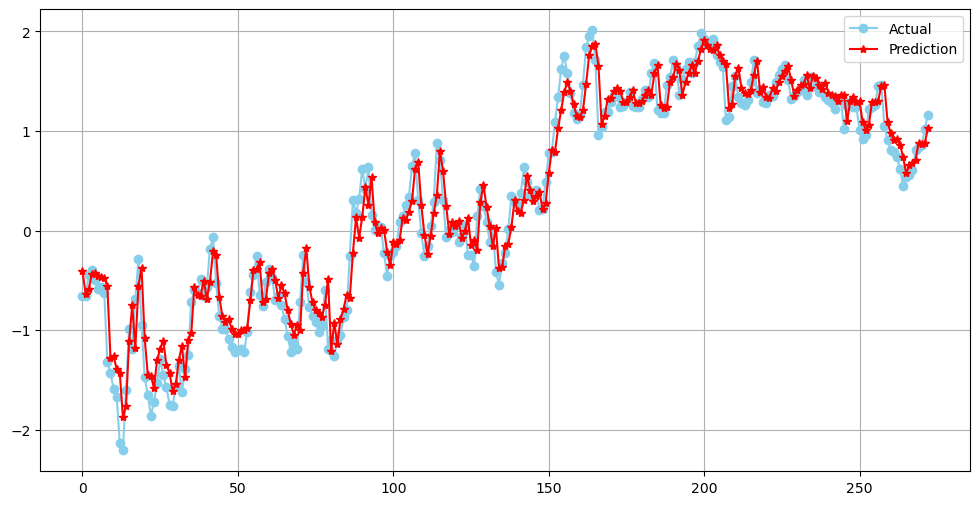

R2 score is:  0.9593874903578852 




In [29]:
plt.figure(figsize=(12,6))
plt.plot(y_test, "-o", label = "Actual", color="skyblue")
plt.plot(y_pred, "-*r", label = "Prediction")
plt.legend()
plt.grid()
plt.show()
print("R2 score is: ", r2_score(y_test, y_pred),"\n\n")

# 7. Multivariate Multi-step Forecasting

## 7.1. Machine Learning - Gradient Boosting

$$x_0, x_1, x_2, x_3, x_4, ... , x_{t-1}$$
$$y_0, y_1, y_2, y_3, y_4, ... , y_{t-1}$$

$$Target: [\hat{x}_3 \quad \hat{x}_4]  = f(x_0, y_0, x_1, y_1, x_2, y_2) $$

$$
\begin{bmatrix}
x_0 & y_0 & x_1 & y_1 & x_2 & y_2 \\
x_1 & y_1 & x_2 & y_2 & x_3 & y_3 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
x_{t-5} & y_{t-5} & x_{t-4} & y_{t-4} & x_{t-3} & y_{t-3} \\
\end{bmatrix}
\quad
\begin{bmatrix}
x_3 & x_4\\
x_4 & x_5\\
\vdots & \vdots \\
x_{t-2} & x_{t-1} \\
\end{bmatrix}
$$

In [30]:
def preprocess(data, lag = 3, target_col = 0, period = 2):
  X = []
  y = []
  for i in range(len(data) - lag - period + 1):
    X.append(data[i : i + lag].ravel())
    y.append(data[i + lag : i + lag + period, target_col])
  return np.array(X), np.array(y)

X, y = preprocess(df, lag = 7, target_col = 0, period = 365)
print(X.shape)
print(y.shape)

(1362, 14)
(1362, 365)


In [31]:
X_train = X[:-1]
y_train = y[:-1]
X_test = X[-1:]
y_test = y[-1:]

In [32]:
from sklearn.multioutput import MultiOutputRegressor

mdl = MultiOutputRegressor(GradientBoostingRegressor())
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)

y_pred = y_pred.ravel()
y_test = y_test.ravel()

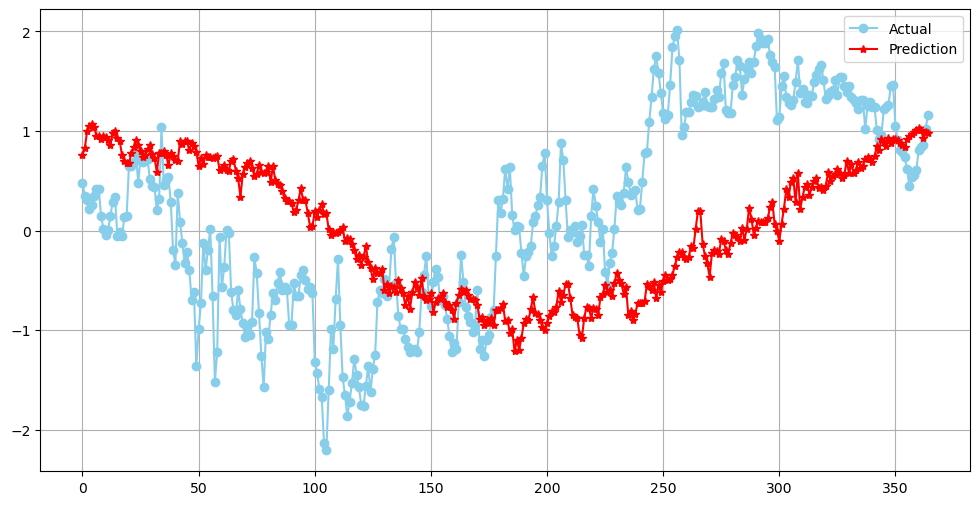

R2 score is:  -0.18463053484342096 




In [33]:
plt.figure(figsize=(12,6))
plt.plot(y_test, "-o", label = "Actual", color="skyblue")
plt.plot(y_pred, "-*r", label = "Prediction")
plt.legend()
plt.grid()
plt.show()
print("R2 score is: ", r2_score(y_test, y_pred),"\n\n")

## 7.2. Deep Learning - LSTM

$$x_0, x_1, x_2, x_3, x_4, ... , x_{t-1}$$
$$y_0, y_1, y_2, y_3, y_4, ... , y_{t-1}$$

$$[\hat{x}_3, \hat{x}_4 ]= f(x_0, y_0, x_1, y_1, x_2, y_2) $$

$$
\begin{bmatrix}
\begin{bmatrix}x_0 & y_0 \\ x_1 & y_1 \\ x_2 & y_2 \end{bmatrix} \\
\begin{bmatrix}x_1 & y_1 \\ x_2 & y_2 \\ x_3 & y_3 \end{bmatrix} \\
\vdots \\
\begin{bmatrix}x_{t-5} & y_{t-5} \\ x_{t-4} & y_{t-4} \\ x_{t-3} & y_{t-3}\end{bmatrix} \\
\end{bmatrix}
\quad
\begin{bmatrix}
x_3 & x_4\\
x_4 & x_5\\
\vdots & \vdots \\
x_{t-2} & x_{t-1} \\
\end{bmatrix}
$$

In [34]:
def make_data(data, lag = 3, target_col = 0, period = 2):
  X = []
  y = []
  for i in range(len(data) - lag - period + 1):
    X.append(data[i : i + lag])
    y.append(data[i + lag : i + lag + period, target_col])
  return np.array(X), np.array(y)

X, y = make_data(df, lag = 365, target_col = 0, period = 7)
print(X.shape)
print(y.shape)

(1362, 365, 2)
(1362, 7)


In [35]:
X_train = X[:-39]
y_train = y[:-39]
X_test = X[-39:]
y_test = y[-39:]

In [36]:
X_train.shape

(1323, 365, 2)

In [37]:
y_train.shape

(1323, 7)

In [38]:
mdl = keras.Sequential()
mdl.add(layers.Input(shape=X_train.shape[1:]))
mdl.add(layers.LSTM(128))
mdl.add(layers.Dense(128, activation = "relu"))
mdl.add(layers.Dense(7, activation = "linear"))

mdl.compile(optimizer = "adam", loss = "mse", metrics = ["mape"])
mdl.fit(X_train, y_train, epochs = 10, verbose = 2)

y_pred = mdl.predict(X_test)

y_pred = y_pred.ravel()
y_test = y_test.ravel()

Epoch 1/10
42/42 - 4s - 107ms/step - loss: 0.3721 - mape: 260.0673
Epoch 2/10
42/42 - 4s - 93ms/step - loss: 0.2266 - mape: 289.9275
Epoch 3/10
42/42 - 4s - 94ms/step - loss: 0.2215 - mape: 290.1518
Epoch 4/10
42/42 - 4s - 94ms/step - loss: 0.2148 - mape: 278.8878
Epoch 5/10
42/42 - 4s - 95ms/step - loss: 0.2147 - mape: 284.4539
Epoch 6/10
42/42 - 4s - 94ms/step - loss: 0.2087 - mape: 275.8251
Epoch 7/10
42/42 - 4s - 94ms/step - loss: 0.2129 - mape: 281.0224
Epoch 8/10
42/42 - 4s - 94ms/step - loss: 0.2086 - mape: 282.6722
Epoch 9/10
42/42 - 4s - 95ms/step - loss: 0.2023 - mape: 271.2881
Epoch 10/10
42/42 - 4s - 94ms/step - loss: 0.1988 - mape: 272.2577
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


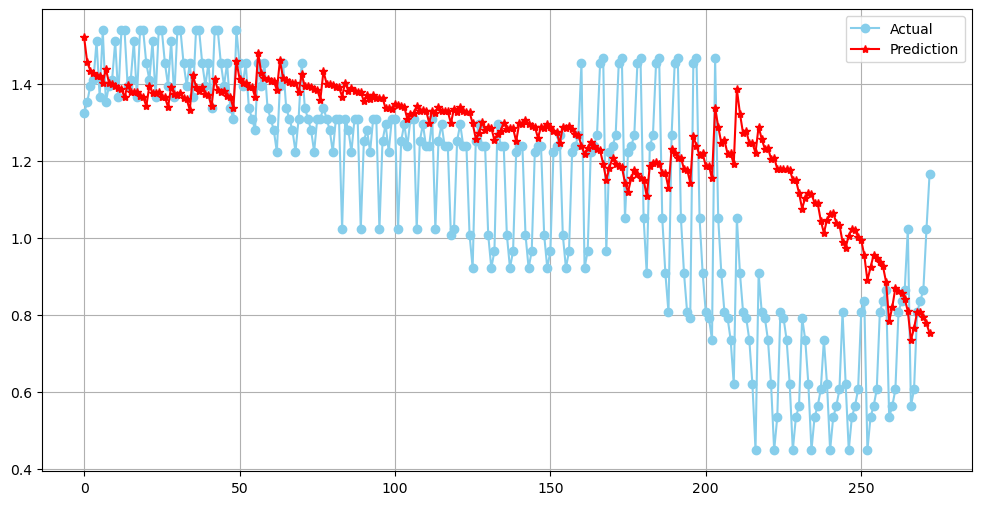

R2 score is:  0.278104451156752 




In [39]:
plt.figure(figsize=(12,6))
plt.plot(y_test, "-o", label = "Actual", color="skyblue")
plt.plot(y_pred, "-*r", label = "Prediction")
plt.legend()
plt.grid()
plt.show()
print("R2 score is: ", r2_score(y_test, y_pred),"\n\n")